<a href="https://colab.research.google.com/github/tabers77/Course-Advance-Machine-Learning-Specialization/blob/master/NLP/week5/peer_assigment_week5_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STEPS:
- Data Preparation:
- Build an intent recognizer
- Tag classifier 


# Final project: StackOverflow assistant bot

Congratulations on coming this far and solving the programming assignments! In this final project, we will combine everything we have learned about Natural Language Processing to construct a *dialogue chat bot*, which will be able to:
* answer programming-related questions (using StackOverflow dataset);
* chit-chat and simulate dialogue on all non programming-related questions.

For a chit-chat mode we will use a pre-trained neural network engine available from [ChatterBot](https://github.com/gunthercox/ChatterBot).
Those who aim at honor certificates for our course or are just curious, will train their own models for chit-chat.
![](https://imgs.xkcd.com/comics/twitter_bot.png)
©[xkcd](https://xkcd.com)

In [ ]:
# Include files from drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data description

To detect *intent* of users questions we will need two text collections:
- `tagged_posts.tsv` — StackOverflow posts, tagged with one programming language (*positive samples*).
- `dialogues.tsv` — dialogue phrases from movie subtitles (*negative samples*).


In [ ]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    ! wget https://raw.githubusercontent.com/hse-aml/natural-language-processing/master/setup_google_colab.py -O setup_google_colab.py
    import setup_google_colab
    setup_google_colab.setup_project()

import sys
sys.path.append("..")
from common.download_utils import download_project_resources

download_project_resources()

--2021-12-20 06:31:06--  https://raw.githubusercontent.com/hse-aml/natural-language-processing/master/setup_google_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1939 (1.9K) [text/plain]
Saving to: ‘setup_google_colab.py’

setup_google_colab. 100%[===================>]   1.89K  --.-KB/s    in 0s      

2021-12-20 06:31:06 (20.7 MB/s) - ‘setup_google_colab.py’ saved [1939/1939]



  0%|          | 0.00/18.0M [00:00<?, ?B/s]

  0%|          | 0.00/146M [00:00<?, ?B/s]

For those questions, that have programming-related intent, we will proceed as follow predict programming language (only one tag per question allowed here) and rank candidates within the tag using embeddings.
For the ranking part, you will need:
- `word_embeddings.tsv` — word embeddings, that you  trained with StarSpace in the 3rd assignment. It's not a problem if you didn't do it, because we can offer an alternative solution for you.

As a result of this notebook, you should obtain the following new objects that you will then use in the running bot:

- `intent_recognizer.pkl` — intent recognition model;
- `tag_classifier.pkl` — programming language classification model;
- `tfidf_vectorizer.pkl` — vectorizer used during training;
- `thread_embeddings_by_tags` — folder with thread embeddings, arranged by tags.
    

Some functions will be reused by this notebook and the scripts, so we put them into *utils.py* file. Don't forget to open it and fill in the gaps!

In [ ]:
from utils import *

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Part I. Intent and language recognition

We want to write a bot, which will not only **answer programming-related questions**, but also will be able to **maintain a dialogue**. We would also like to detect the *intent* of the user from the question (we could have had a 'Question answering mode' check-box in the bot, but it wouldn't fun at all, would it?). So the first thing we need to do is to **distinguish programming-related questions from general ones**.

It would also be good to predict which programming language a particular question referees to. By doing so, we will speed up question search by a factor of the number of languages (10 here), and exercise our *text classification* skill a bit. :)

In [ ]:
import numpy as np
import pandas as pd
import pickle
import re

from sklearn.feature_extraction.text import TfidfVectorizer

### Data preparation

In the first assignment (Predict tags on StackOverflow with linear models), you have already learnt how to preprocess texts and do TF-IDF tranformations. Reuse your code here. In addition, you will also need to [dump](https://docs.python.org/3/library/pickle.html#pickle.dump) the TF-IDF vectorizer with pickle to use it later in the running bot.

In [ ]:
import pickle

def tfidf_features(X_train, X_test, vectorizer_path):
    """Performs TF-IDF transformation and dumps the model."""
    
    # Train a vectorizer on X_train data.
    # Transform X_train and X_test data.
    
    # Pickle the trained vectorizer to 'vectorizer_path'
    # Don't forget to open the file in writing bytes mode.
    
    ######################################
    ######### YOUR CODE HERE #############
    ######################################

    tfidf_vectorizer = TfidfVectorizer(min_df=5, max_df=0.9, ngram_range=(1, 2), token_pattern='(\S+)') 
    X_train = tfidf_vectorizer.fit_transform(X_train)
    X_test = tfidf_vectorizer.transform(X_test)
  
    with open(vectorizer_path, 'wb') as f:
      pickle.dump(tfidf_vectorizer, f)
    
    return X_train, X_test

Now, load examples of two classes. Use a subsample of stackoverflow data to balance the classes. You will need the full data later.

In [ ]:
# Load input data

sample_size = 200000

dialogue_df = pd.read_csv('data/dialogues.tsv', sep='\t').sample(sample_size, random_state=0)
stackoverflow_df = pd.read_csv('data/tagged_posts.tsv', sep='\t').sample(sample_size, random_state=0)

Check how the data look like:

In [ ]:
print(dialogue_df.shape)
dialogue_df.head()

(200000, 2)


,text,tag
82925,"Donna, you are a muffin.",dialogue
48774,He was here last night till about two o'clock....,dialogue
55394,"All right, then make an appointment with her s...",dialogue
90806,"Hey, what is this-an interview? We're supposed...",dialogue
107758,Yeah. He's just a friend of mine I was trying ...,dialogue


In [ ]:
print(stackoverflow_df.shape)
stackoverflow_df.head()

(200000, 3)


,post_id,title,tag
2168983,43837842,Efficient Algorithm to compose valid expressio...,python
1084095,15747223,Why does this basic thread program fail with C...,c_cpp
1049020,15189594,Link to scroll to top not working,javascript
200466,3273927,Is it possible to implement ping on windows ph...,c#
1200249,17684551,GLSL normal mapping issue,c_cpp


Apply *text_prepare* function to preprocess the data.

If you filled in the file, but NotImplementedError is still displayed, please refer to [this thread](https://github.com/hse-aml/natural-language-processing/issues/27).

In [ ]:
from utils import text_prepare

In [ ]:
# Text preparation

dialogue_df['text'] = dialogue_df['text'].apply(lambda x: text_prepare(x) )######### YOUR CODE HERE #############
stackoverflow_df['title'] = stackoverflow_df['title'].apply(lambda x: text_prepare(x))  ######### YOUR CODE HERE #############

In [ ]:
dialogue_df.head()

,text,tag
82925,donna muffin,dialogue
48774,last night till two oclock hear really got stu...,dialogue
55394,right make appointment see,dialogue
90806,hey thisan interview supposed making love,dialogue
107758,yeah hes friend mine trying help,dialogue


### Intent recognition

We will do a binary classification on TF-IDF representations of texts. Labels will be either `dialogue` for general questions or `stackoverflow` for programming-related questions. First, prepare the data for this task:
- concatenate `dialogue` and `stackoverflow` examples into one sample
- split it into train and test in proportion 9:1, use *random_state=0* for reproducibility
- transform it into TF-IDF features

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Concatenate text and title
X = np.concatenate([dialogue_df['text'].values, stackoverflow_df['title'].values])

y = ['dialogue'] * dialogue_df.shape[0] + ['stackoverflow'] * stackoverflow_df.shape[0]

# Train and test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, random_state=0) ######### YOUR CODE HERE ##########
print('Train size = {}, test size = {}'.format(len(X_train), len(X_test)))

# Generate TFIDF features
X_train_tfidf, X_test_tfidf = tfidf_features(X_train, X_test, RESOURCE_PATH['TFIDF_VECTORIZER'])######### YOUR CODE HERE ###########

Train size = 360000, test size = 40000


Train the **intent recognizer** using LogisticRegression on the train set with the following parameters: *penalty='l2'*, *C=10*, *random_state=0*. Print out the accuracy on the test set to check whether everything looks good.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [ ]:
######################################
######### YOUR CODE HERE #############
######################################
# Model 
intent_recognizer = LogisticRegression(penalty = 'l2', C= 10, random_state= 0, solver='liblinear')

# Here we fit the TFIDF version of X_train

intent_recognizer.fit(X_train_tfidf, y_train)

LogisticRegression(C=10, random_state=0, solver='liblinear')

In [ ]:
# Check test accuracy...
y_test_pred = intent_recognizer.predict(X_test_tfidf)
test_accuracy = accuracy_score(y_test, y_test_pred)
print('Test accuracy = {}'.format(test_accuracy))

Test accuracy = 0.991575


Dump the classifier to use it in the running bot.

In [ ]:
# Dump classifier - This model will be then used for the final model

pickle.dump(intent_recognizer, open(RESOURCE_PATH['INTENT_RECOGNIZER'], 'wb'))

### Programming language classification 

We will train one more classifier for the programming-related questions. It will predict exactly one tag (=programming language) and will be also based on Logistic Regression with TF-IDF features. 

First, let us prepare the data for this task.

In [ ]:
X = stackoverflow_df['title'].values
y = stackoverflow_df['tag'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print('Train size = {}, test size = {}'.format(len(X_train), len(X_test)))

Train size = 160000, test size = 40000


Let us reuse the TF-IDF vectorizer that we have already created above. It should not make a huge difference which data was used to train it.

In [ ]:
# Here we re use the intent_recognizer we trained before. 
#OBS that It should not make a huge difference which data was used to train it.
vectorizer = pickle.load(open(RESOURCE_PATH['TFIDF_VECTORIZER'], 'rb'))
# Transform X_train and X_test
X_train_tfidf, X_test_tfidf = vectorizer.transform(X_train), vectorizer.transform(X_test)

Train the **tag classifier** using OneVsRestClassifier wrapper over LogisticRegression. Use the following parameters: *penalty='l2'*, *C=5*, *random_state=0*.

In [ ]:
from sklearn.multiclass import OneVsRestClassifier

In [ ]:
######################################
######### YOUR CODE HERE #############
######################################


tag_classifier = OneVsRestClassifier(LogisticRegression(penalty='l2', C=5, random_state=0, solver='liblinear'))

# Here we used the vectorized  train and test 
tag_classifier.fit(X_train_tfidf, y_train)

OneVsRestClassifier(estimator=LogisticRegression(C=5, random_state=0,
                                                 solver='liblinear'))

In [ ]:
# Check test accuracy.
y_test_pred = tag_classifier.predict(X_test_tfidf)
test_accuracy = accuracy_score(y_test, y_test_pred)
print('Test accuracy = {}'.format(test_accuracy))

Test accuracy = 0.800725


Dump the classifier to use it in the running bot.

In [ ]:
pickle.dump(tag_classifier, open(RESOURCE_PATH['TAG_CLASSIFIER'], 'wb'))

## Part II. Ranking  questions with embeddings

To find a relevant answer (a thread from StackOverflow) on a question you will use vector representations to calculate similarity between the question and existing threads. We already had `question_to_vec` function from the assignment 3, which can create such a representation based on word vectors. 

However, it would be costly to compute such a representation for all possible answers in *online mode* of the bot (e.g. when bot is running and answering questions from many users). This is the reason why you will create a *database* with pre-computed representations. These representations will be arranged by non-overlaping tags (programming languages), so that the search of the answer can be performed only within one tag each time. This will make our bot even more efficient and allow not to store all the database in RAM. 

Load StarSpace embeddings which were trained on Stack Overflow posts. These embeddings were trained in *supervised mode* for duplicates detection on the same corpus that is used in search. We can account on that these representations will allow us to find closely related answers for a question. 

If for some reasons you didn't train StarSpace embeddings in the assignment 3, you can use [pre-trained word vectors](https://code.google.com/archive/p/word2vec/) from Google. All instructions about how to work with these vectors were provided in the same assignment. However, we highly recommend to use StarSpace's embeddings, because it contains more appropriate embeddings. If you chose to use Google's embeddings, delete the words, which are not in Stackoverflow data.

In [ ]:
# # Using download resources from week 3 
# from common.download_utils import download_week3_resources
# download_week3_resources()

In [ ]:
#! shred utils.py

In [ ]:
RESOURCE_PATH

{'INTENT_RECOGNIZER': 'intent_recognizer.pkl',
 'TAG_CLASSIFIER': 'tag_classifier.pkl',
 'TFIDF_VECTORIZER': 'tfidf_vectorizer.pkl',
 'THREAD_EMBEDDINGS_FOLDER': 'thread_embeddings_by_tags',
 'WORD_EMBEDDINGS': 'data/word_embeddings.tsv'}

In [ ]:
import sys
sys.path.append("..")
from common.download_utils import download_week3_resources

download_week3_resources()

  0%|          | 0.00/119M [00:00<?, ?B/s]

  0%|          | 0.00/536M [00:00<?, ?B/s]

  0%|          | 0.00/46.4M [00:00<?, ?B/s]

  0%|          | 0.00/5.33k [00:00<?, ?B/s]

  0%|          | 0.00/1.65G [00:00<?, ?B/s]

In [ ]:
from gensim.models import KeyedVectors

wv_embeddings = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True, limit = 500000 )

In [ ]:
!ls

common				       sample_data
data				       setup_google_colab.py
dialogue_manager.py		       Starspace
GoogleNews-vectors-negative300.bin.gz  tag_classifier.pkl
intent_recognizer.pkl		       tfidf_vectorizer.pkl
__pycache__			       utils.py


In [ ]:
!ls data 

dialogues.tsv	  test_embeddings.tsv  train.tsv
tagged_posts.tsv  test.tsv	       validation.tsv


In [ ]:
# TEMPORARY SOLUTION 

def load_embeddings(embeddings_path):
    """Loads pre-trained word embeddings from tsv file.
    Args:
      embeddings_path - path to the embeddings file.
    Returns:
      embeddings - dict mapping words to vectors;
      embeddings_dim - dimension of the vectors.
    """
    
    # Hint: you have already implemented a similar routine in the 3rd assignment.
    # Note that here you also need to know the dimension of the loaded embeddings.
    # When you load the embeddings, use numpy.float32 type as dtype

    ########################
    #### YOUR CODE HERE ####
    ########################

    embeddings = {}
    for line in open(embeddings_path, encoding='utf-8'):
        word, *vec = line.strip().split('\t')
        embeddings_dim = len(vec)
        embeddings[word] = np.array(vec, dtype=np.float32)

    return embeddings, embeddings_dim

def question_to_vec(question, embeddings, dim):
    """Transforms a string to an embedding by averaging word embeddings."""
    
    # Hint: you have already implemented exactly this function in the 3rd assignment.

    ########################
    #### YOUR CODE HERE ####
    ########################

    result = np.zeros(dim, dtype=np.float32)
    count = 0
    for word in question.split():
        if word in embeddings:
            result += embeddings[word]
            count += 1
    return result / count if count != 0 else result

# Here we would need to train the embeddings to generate the tsv file 

starspace_embeddings, embeddings_dim = load_embeddings('/content/drive/MyDrive/StarSpace_embeddings.tsv')


Since we want to precompute representations for all possible answers, we need to load the whole posts dataset, unlike we did for the intent classifier:

In [ ]:
posts_df = pd.read_csv('data/tagged_posts.tsv', sep='\t')

Look at the distribution of posts for programming languages (tags) and find the most common ones. 
You might want to use pandas [groupby](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html) and [count](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.count.html) methods:

In [ ]:
counts_by_tag = posts_df.groupby('tag')['tag'].count() 

Now for each `tag` you need to create two data structures, which will serve as online search index:
* `tag_post_ids` — a list of post_ids with shape `(counts_by_tag[tag],)`. It will be needed to show the title and link to the thread;
* `tag_vectors` — a matrix with shape `(counts_by_tag[tag], embeddings_dim)` where embeddings for each answer are stored.

Implement the code which will calculate the mentioned structures and dump it to files. It should take several minutes to compute it.

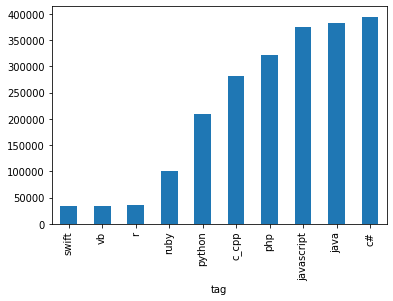

In [ ]:
# Example output: 

counts_by_tag.sort_values().plot(kind = 'bar')


In [ ]:
import os
os.makedirs(RESOURCE_PATH['THREAD_EMBEDDINGS_FOLDER'], exist_ok=True)

for tag, count in counts_by_tag.items():
    tag_posts = posts_df[posts_df['tag'] == tag]
    tag_post_ids = posts_df.post_id.values    
    tag_vectors = np.zeros((count, embeddings_dim), dtype=np.float32)
    for i, title in enumerate(tag_posts['title']):
        tag_vectors[i, :] = question_to_vec(title, starspace_embeddings, embeddings_dim) ######### YOUR CODE HERE ############# 

    # Dump post ids and vectors to a file.
    filename = os.path.join(RESOURCE_PATH['THREAD_EMBEDDINGS_FOLDER'], os.path.normpath('%s.pkl' % tag))
    pickle.dump((tag_post_ids, tag_vectors), open(filename, 'wb'))

## Part III. Putting all together

Now let's combine everything that we have done and enable the bot to maintain a dialogue. We will teach the bot to sequentially determine the intent and, depending on the intent, select the best answer. As soon as we do this, we will have the opportunity to chat with the bot and check how well it answers questions.

Implement Dialogue Manager that will generate the best answer. In order to do this, you should open *dialogue_manager.py* and fill in the gaps.

In [ ]:
# Install chaterbot
!pip install chatterbot
!pip install chatterbot_corpus

     |████████████████████████████████| 63 kB 2.1 MB/s 
     |████████████████████████████████| 1.3 MB 48.2 MB/s 
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 1.4.27
    Uninstalling SQLAlchemy-1.4.27:
      Successfully uninstalled SQLAlchemy-1.4.27
     |████████████████████████████████| 117 kB 33.8 MB/s 


### utils.py - dialogue_manager.py

In [ ]:
#from dialogue_manager import DialogueManager 

# TEMPORARY SOLUTION

#**************** utils.py ****************

import nltk
import pickle
import re
import numpy as np

nltk.download('stopwords')
from nltk.corpus import stopwords

# Paths for all resources for the bot.
RESOURCE_PATH = {
    'INTENT_RECOGNIZER': 'intent_recognizer.pkl',
    'TAG_CLASSIFIER': 'tag_classifier.pkl',
    'TFIDF_VECTORIZER': 'tfidf_vectorizer.pkl',
    'THREAD_EMBEDDINGS_FOLDER': 'thread_embeddings_by_tags',
    'WORD_EMBEDDINGS':'word_embeddings.tsv' #'word_embeddings.tsv', '/content/data/test_embeddings.tsv' # 
    
}


def text_prepare(text):
    """Performs tokenization and simple preprocessing."""
    
    replace_by_space_re = re.compile('[/(){}\[\]\|@,;]')
    bad_symbols_re = re.compile('[^0-9a-z #+_]')
    stopwords_set = set(stopwords.words('english'))

    text = text.lower()
    text = replace_by_space_re.sub(' ', text)
    text = bad_symbols_re.sub('', text)
    text = ' '.join([x for x in text.split() if x and x not in stopwords_set])

    return text.strip()


def load_embeddings(embeddings_path):
    """Loads pre-trained word embeddings from tsv file.

    Args:
      embeddings_path - path to the embeddings file.

    Returns:
      embeddings - dict mapping words to vectors;
      embeddings_dim - dimension of the vectors.
    """
    
    # Hint: you have already implemented a similar routine in the 3rd assignment.
    # Note that here you also need to know the dimension of the loaded embeddings.
    # When you load the embeddings, use numpy.float32 type as dtype

    ########################
    #### YOUR CODE HERE ####
    ########################

    embeddings = {}
    for line in open(embeddings_path, encoding='utf-8'):
        word, *vec = line.strip().split('\t')
        embeddings_dim = len(vec)
        embeddings[word] = np.array(vec, dtype=np.float32)

    return embeddings, embeddings_dim

def question_to_vec(question, embeddings, dim):
    """Transforms a string to an embedding by averaging word embeddings."""
    
    # Hint: you have already implemented exactly this function in the 3rd assignment.

    ########################
    #### YOUR CODE HERE ####
    ########################

    result = np.zeros(dim, dtype=np.float32)
    count = 0
    for word in question.split():
        if word in embeddings:
            result += embeddings[word]
            count += 1
    return result / count if count != 0 else result


def unpickle_file(filename):
    """Returns the result of unpickling the file content."""
    with open(filename, 'rb') as f:
        return pickle.load(f)

#**************** utils.py ****************

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# TEMPORARY SOLUTION

#**************** dialogue_manager.py ****************
import os
from sklearn.metrics.pairwise import pairwise_distances_argmin
from chatterbot import ChatBot
from chatterbot.trainers import ChatterBotCorpusTrainer
#from utils import *


class ThreadRanker(object):

    def __init__(self, paths):
        self.word_embeddings, self.embeddings_dim = load_embeddings(paths['WORD_EMBEDDINGS'])
        self.thread_embeddings_folder = paths['THREAD_EMBEDDINGS_FOLDER']

    def __load_embeddings_by_tag(self, tag_name):
        embeddings_path = os.path.join(self.thread_embeddings_folder, tag_name + ".pkl")
        
        thread_ids, thread_embeddings = unpickle_file(embeddings_path)
        #print(f'ids: {thread_ids}')
        #print(f'embeddings: {thread_embeddings}')
        return thread_ids, thread_embeddings

    def get_best_thread(self, question, tag_name):
        """ Returns id of the most similar thread for the question.
            The search is performed across the threads with a given tag.
        """
        
        thread_ids, thread_embeddings = self.__load_embeddings_by_tag(tag_name)
        # HINT: you have already implemented a similar routine in the 3rd assignment.
        
        question_vec = question_to_vec(question, self.word_embeddings, self.embeddings_dim)[np.newaxis, :] #### YOUR CODE HERE ####
        
        best_thread = pairwise_distances_argmin(question_vec, thread_embeddings, metric='cosine')[0] #### YOUR CODE HERE ####
        #print(thread_embeddings)
        #print(question_vec)
        return thread_ids[best_thread]


class DialogueManager(object):
    def __init__(self, paths):
        print("Loading resources...")

        # Intent recognition:
        self.intent_recognizer = unpickle_file(paths['INTENT_RECOGNIZER'])
        self.tfidf_vectorizer = unpickle_file(paths['TFIDF_VECTORIZER'])

        self.ANSWER_TEMPLATE = 'I think its about %s\nThis thread might help you: https://stackoverflow.com/questions/%s'

        # Goal-oriented part:
        self.tag_classifier = unpickle_file(paths['TAG_CLASSIFIER'])
        self.thread_ranker = ThreadRanker(paths)
        self.__init_chitchat_bot()

    def __init_chitchat_bot(self):
        """Initializes self.chitchat_bot with some conversational model."""

        # Hint: you might want to create and train chatterbot.ChatBot here.
        # Create an instance of the ChatBot class.
        # Set a trainer set_trainer(ChatterBotCorpusTrainer) for the ChatBot.
        # Train the ChatBot with "chatterbot.corpus.english" param.
        # Note that we use chatterbot==0.7.6 in this project. 
        # You are welcome to experiment with other versions but they might have slightly different API.
        
        ########################
        #### YOUR CODE HERE ####
        ########################
        chatbot = ChatBot('my_bot')
        trainer = ChatterBotCorpusTrainer(chatbot)
        trainer.train("chatterbot.corpus.english")

        self.chitchat_bot = chatbot

  
    def generate_answer(self, question):
        """Combines stackoverflow and chitchat parts using intent recognition."""

        # Recognize intent of the question using `intent_recognizer`.
        # Don't forget to prepare question and calculate features for the question.
        
        prepared_question = text_prepare(question) #### YOUR CODE HERE ####
        features = self.tfidf_vectorizer.transform([prepared_question]) #### YOUR CODE HERE ####
        intent = self.intent_recognizer.predict(features)[0]#### YOUR CODE HERE ####

        # Chit-chat part:   
        if intent == 'dialogue':
            # Pass question to chitchat_bot to generate a response.       
            response = self.chitchat_bot.get_response(question) #### YOUR CODE HERE ####
            return response
        
        # Goal-oriented part:
        else:        
            # Pass features to tag_classifier to get predictions.
            tag =  self.tag_classifier.predict(features)[0] #### YOUR CODE HERE ####
            print(f'tag classfier passed: {tag}')
            print(f'p question:{prepared_question}')
            
            # Pass prepared_question to thread_ranker to get predictions.
            thread_id = self.thread_ranker.get_best_thread(prepared_question, tag) #### YOUR CODE HERE ####

            return self.ANSWER_TEMPLATE % (tag, thread_id)

#**************** dialogue_manager.py ****************

In [ ]:
dialogue_manager = DialogueManager(RESOURCE_PATH) ######### YOUR CODE HERE #############

Loading resources...
Training ai.yml: [####################] 100%
Training botprofile.yml: [####################] 100%
Training computers.yml: [####################] 100%
Training conversations.yml: [####################] 100%
Training emotion.yml: [####################] 100%
Training food.yml: [####################] 100%
Training gossip.yml: [####################] 100%
Training greetings.yml: [####################] 100%
Training health.yml: [####################] 100%
Training history.yml: [####################] 100%
Training humor.yml: [####################] 100%
Training literature.yml: [####################] 100%
Training money.yml: [####################] 100%
Training movies.yml: [####################] 100%
Training politics.yml: [####################] 100%
Training psychology.yml: [####################] 100%
Training science.yml: [####################] 100%
Training sports.yml: [####################] 100%
Training trivia.yml: [####################] 100%


In [ ]:
dialogue_manager.generate_answer( "How to write a loop in python?")

tag classfier passed: python
p question:write loop python


'I think its about python\nThis thread might help you: https://stackoverflow.com/questions/367494'

Now we are ready to test our chat bot! Let's chat with the bot and ask it some questions. Check that the answers are reasonable.

In [ ]:
questions = [
    "Hey", 
    "How are you doing?", 
    "What's your hobby?", 
    "How to write a loop in python?",
    "How to delete rows in pandas?",
    "python3 re",
    "What is the difference between c and c++",
    "Multithreading in Java",
    "Catch exceptions C++",
    "What is AI?",
]

for question in questions:
  
  answer =dialogue_manager.generate_answer(question) ######### YOUR CODE HERE #############
  print('Q: %s\nA: %s \n' % (question, answer))

Q: Hey
A: a secret organization believed by some to be in control of all governments through a worldwide conspiracy. 

Q: How are you doing?
A: I am doing well. 

Q: What's your hobby?
A: Playing Soccer, Painting, Writing are my hobbies. How about you? 

tag classfier passed: python
p question:write loop python
Q: How to write a loop in python?
A: I think its about python
This thread might help you: https://stackoverflow.com/questions/367494 

tag classfier passed: python
p question:delete rows pandas
Q: How to delete rows in pandas?
A: I think its about python
This thread might help you: https://stackoverflow.com/questions/3305516 

tag classfier passed: python
p question:python3
Q: python3 re
A: I think its about python
This thread might help you: https://stackoverflow.com/questions/1196492 

tag classfier passed: c_cpp
p question:difference c c++
Q: What is the difference between c and c++
A: I think its about c_cpp
This thread might help you: https://stackoverflow.com/questions/368

In [ ]:

while True:

  user_input = input('ask me a question: ')
  answer =dialogue_manager.generate_answer(user_input)
  print('Q: %s\nA: %s \n' % (user_input, answer))
  break_question = input('Do you have more questions? y/n: ')
  if break_question == 'n':
    print('Ok, good bye...')
    break


ask me a question: jhjh


NameError: ignored